<a href="https://colab.research.google.com/github/IreneLedyaeva/CAP-5610/blob/master/HW3/problem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Feature extraction with data augmentation

### Downloading the cats vs dogs data

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-10 00:11:19--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  80.2MB/s    in 0.8s    

2019-04-10 00:11:25 (80.2 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### Extracting the data locally in /tmp

In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

### Training and validation directories

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### Loading the convolutional base of VGG19

In [0]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 21s 0us/step


### Freezing the convolutional base weights

In [0]:
conv_base.trainable = False

### Building the model by adding new dense layers

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


### Data augmentation
Validation data should not be augmented

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Running the model

In [0]:
from keras import optimizers

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=25)

50/50 [==============================] - 442s 9s/step - loss: 0.6539 - acc: 0.6190 - val_loss: 0.5816 - val_acc: 0.7020
Epoch 2/30
50/50 [==============================] - 439s 9s/step - loss: 0.5855 - acc: 0.7320 - val_loss: 0.4866 - val_acc: 0.7980
Epoch 3/30
50/50 [==============================] - 438s 9s/step - loss: 0.5366 - acc: 0.7450 - val_loss: 0.4612 - val_acc: 0.7980
Epoch 4/30
50/50 [==============================] - 438s 9s/step - loss: 0.5144 - acc: 0.7420 - val_loss: 0.4245 - val_acc: 0.7900
Epoch 5/30
50/50 [==============================] - 439s 9s/step - loss: 0.4734 - acc: 0.7810 - val_loss: 0.3992 - val_acc: 0.8200
Epoch 6/30
50/50 [==============================] - 441s 9s/step - loss: 0.4862 - acc: 0.7630 - val_loss: 0.3896 - val_acc: 0.8340
Epoch 7/30
50/50 [==============================] - 440s 9s/step - loss: 0.4488 - acc: 0.7880 - val_loss: 0.3707 - val_acc: 0.8380
Epoch 8/30
50/50 [==============================] - 438s 9s/step - loss: 0.4702 - acc: 0.7790 

### Checking overfitting

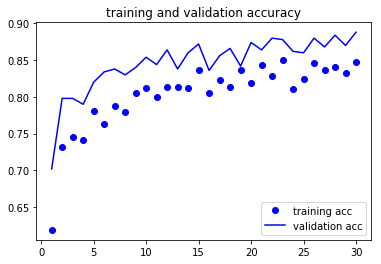

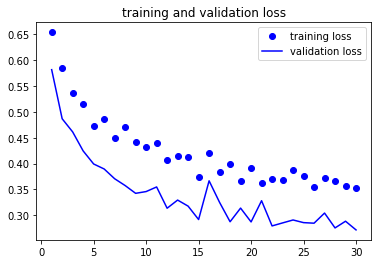

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

### Printing out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=25)

In [0]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.2707520940899849
Validation accuracy: 0.8859999990463256


### Saving the model

In [0]:
model_fname = 'cats_and_dogs_pretrained.h5' 
model.save(model_fname)

from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)